### SPH-Interpolators
`pgpy` allows to interpolate fields from tracers (particles) to arbitrary coordinates. The used interpolation kernel is a quintic spline.\
The central class is the `sph_interpolator` class that is initialized as follows
- `particle_positions`:   particle positions of shape (N, dim)
- `particle_masses`:  particle masses
- `boxsize`:    boxsize of periodic box
- `number_of_nn`: number of nearest neighbors to use when interpolating

The central routine is the `query_field_at_positions` function, that takes as input the field values `particle_field` and the query coordinates.\
It returns the interpolated field values at those positions.

In [1]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from sph_modules import sph_interpolator, create_grid_2d, create_grid_3d

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Interpolation: 2d grid
Let's interpolate the surface density $\sigma$ and the temperature field.

In [2]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N256/snapshot_344.hdf5')


boxsize = 15000
NN = 128

pos    = ds.gas['pos']
masses = ds.gas['mass']

mask = np.logical_and(pos[:, -1] > 13500,
                      pos[:, -1] < 15000)
pos  = pos[mask]
masses = masses[mask]

Interpolator = sph_interpolator(pos[:, :2],
                                masses, 
                                boxsize, NN)

/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:555: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/home/maurbe/data/conda/envs/wenv/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:394: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")


Init: 	 computing 2d hsm and ρ


In [3]:
nx = 500
grid_2d = create_grid_2d(nx, nx, boxsize)

# Mass deposit does not make sense -> deposit density instead
σ       = Interpolator.rho
σ_grid  = Interpolator.query_field_at_positions(σ,
                                                grid_2d)
t_grid  = Interpolator.query_field_at_positions(ds.gas['temp'][mask], 
                                                grid_2d)
v_grid  = Interpolator.query_field_at_positions(ds.gas['vel'][:, 0][mask], 
                                                grid_2d)

σ_grid  = σ_grid.reshape((nx, nx))
t_grid  = t_grid.reshape((nx, nx))
v_grid  = v_grid.reshape((nx, nx))

Query: 	 querying values at coordinates
Query: 	 querying values at coordinates
Query: 	 querying values at coordinates


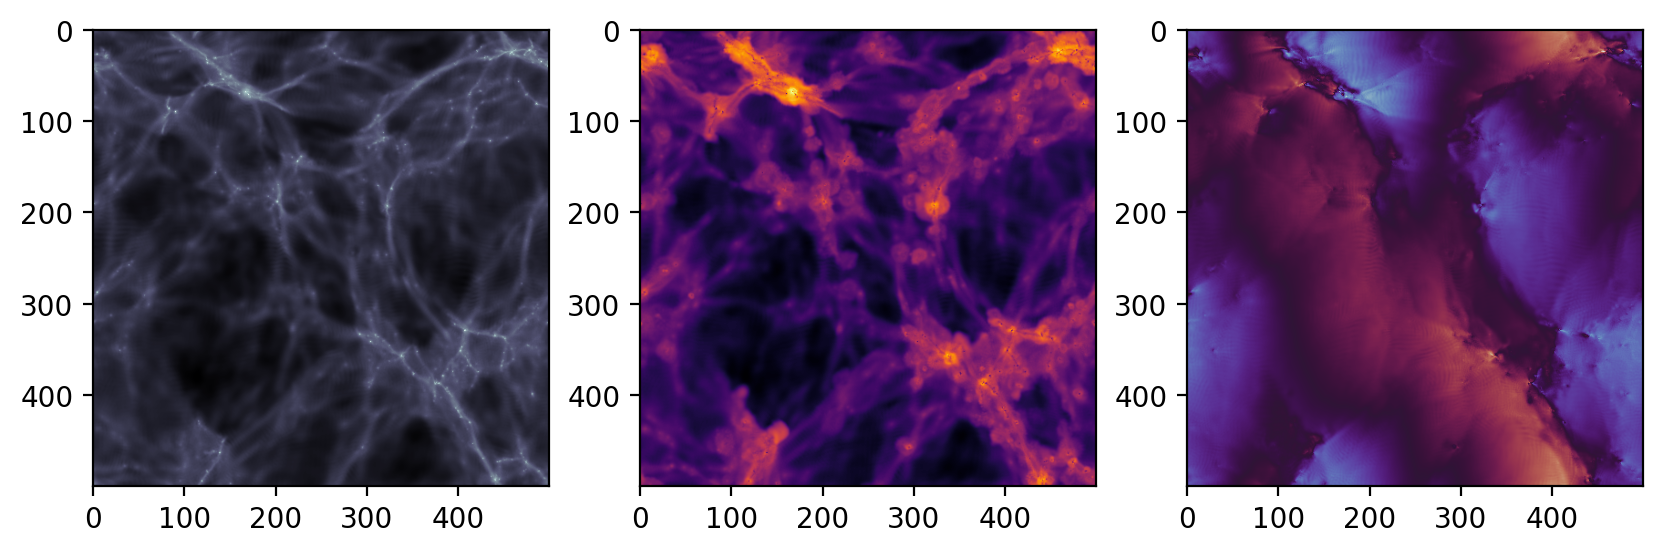

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(np.rot90(np.log10(σ_grid)), cmap='bone')
ax[1].imshow(np.rot90(np.log10(t_grid)), cmap='inferno')
ax[2].imshow(np.rot90(v_grid), cmap='twilight')

plt.savefig('plots/interpolation_2d.png', transparent=True, dpi=300)
plt.show()

In [5]:
total_mass_sim = masses.sum()
total_mass_grid = σ_grid.mean() * boxsize**2
print('Error on mass conservation:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Error on mass conservation: 0.9399511060584009 %


#### Interpolation: 3d grid
The difference between 2d and 3d interpolation is the computation of the smoothing length of particles,\
which is either computing the 2d "surface" smoothing circle or 3d smoothing sphere.

In [6]:
ds = pn.load('../../../../../shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_344.hdf5')

nx = 100
NN = 32

pos    = ds.gas['pos']
masses = ds.gas['mass']

Interpolator = sph_interpolator(pos, masses, boxsize, NN)

Init: 	 computing 3d hsm and ρ


In [7]:
grid_3d = create_grid_3d(nx, nx, nx, boxsize)

ρ       = Interpolator.rho
ρ_grid  = Interpolator.query_field_at_positions(ρ, 
                                                grid_3d)
ρ_grid  = ρ_grid.reshape((nx, nx, nx))


Query: 	 querying values at coordinates


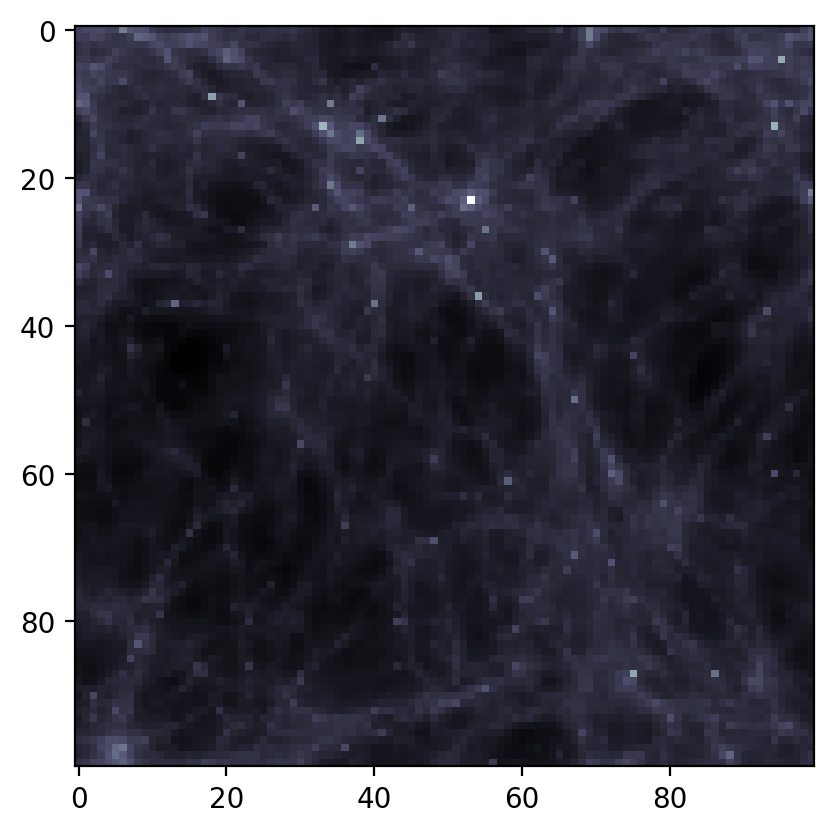

In [8]:
plt.figure()
plt.imshow(np.rot90(np.log10(ρ_grid.sum(axis=-1))), cmap='bone')
plt.show()

In [9]:
total_mass_sim = masses.sum()
total_mass_grid = ρ_grid.mean() * boxsize**3

print('Error on mass conservation:', abs(100 * (1-total_mass_sim / total_mass_grid)), '%')

Error on mass conservation: 5.028376016327963 %
